# 의미 연결망 분석(Semantic Network Analysis)

- 사회 연결망 분석 기법을 텍스트 내 단어의 관계에 적용
- 의미 연결망 분석에서는 일정한 범위 내에서 어휘가 동시에 등장하면 서로 연결된 것으로 간주, 이 연결 관계들을 분석

## n-gram

- 단어의 앞, 뒤 단어를 함께 묶어서 n개 토큰화
- n-gram을 생성할 수 있는 함수를 제공

In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [2]:
from nltk import word_tokenize, bigrams

sentence = 'I love data science and deep learning'
tokens = word_tokenize(sentence) 

bgram = bigrams(tokens)
bgram_list = [x for x in bgram]

print(bgram_list)

[('I', 'love'), ('love', 'data'), ('data', 'science'), ('science', 'and'), ('and', 'deep'), ('deep', 'learning')]


In [3]:
from nltk.util import ngrams 

tgram = ngrams(tokens, 3)
qgram = ngrams(tokens, 4) 

tgram_list = [x for x in tgram]
qgram_list = [x for x in qgram] 

print(tgram_list)
print(qgram_list)

[('I', 'love', 'data'), ('love', 'data', 'science'), ('data', 'science', 'and'), ('science', 'and', 'deep'), ('and', 'deep', 'learning')]
[('I', 'love', 'data', 'science'), ('love', 'data', 'science', 'and'), ('data', 'science', 'and', 'deep'), ('science', 'and', 'deep', 'learning')]


# 어휘 동시 출현 빈도의 계수화

- 동시 출현(Co-occurrence)란 두 개 이상의 어휘가 일정한 범위나 거리 내에서 함께 출현하는 것을 의미
- 단어간의 동시 출현 관계를 분석하면 문서나 문장으로부터 두 단어가 유사한 의미를 가졌는지 등의 추상화된 정보를 얻을 수 있음
- 동시 출현 빈도는 Window라는 지정 범위 내에서 동시 등장한 어휘를 확률 등으로 계수화 가능
- 어휘 동시 출현 빈도 행렬은 하나하나 측정할 수도 있지만, 바이그램 개수를 정리하면 편리하게 만들어 볼 수 있음
- nltk에서 제공하는 ConditionalFreqDist함수를 이용하면 문맥별 단어 빈도를 쉽게 측정 가능

In [4]:
from nltk import ConditionalFreqDist

sentences = ['I love data science and deep learning', 'I love science', 'I know this code']
tokens = [word_tokenize(x) for x in sentences]
bgrams = [bigrams(x, pad_left=True, pad_right=True, 
                  left_pad_symbol="SS", right_pad_symbol="SE") for x in tokens] 
token = []
for i in bgrams: 
    token += ([x for x in i]) 
    
cfd = ConditionalFreqDist(token)
cfd.conditions() 

['SS',
 'I',
 'love',
 'data',
 'science',
 'and',
 'deep',
 'learning',
 'know',
 'this',
 'code']

In [5]:
print(cfd['I'])

<FreqDist with 2 samples and 3 outcomes>


In [6]:
print(cfd['I']['love'])

2


In [7]:
print(cfd['I'].most_common(1))

[('love', 2)]


In [10]:
import numpy as np

freq_matrix = []

for i in cfd.keys():
    temp = []
    for j in cfd.keys():
        temp.append(cfd[i][j])
    freq_matrix.append(temp)
freq_matrix = np.array(freq_matrix)
    
print(cfd.keys())
print(freq_matrix)

dict_keys(['SS', 'I', 'love', 'data', 'science', 'and', 'deep', 'learning', 'know', 'this', 'code'])
[[0 3 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 1 0 0]
 [0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]]


In [11]:
import pandas as pd 

df = pd.DataFrame(freq_matrix, index=cfd.keys(), columns=cfd.keys())
df.style.background_gradient(cmap='coolwarm')

,SS,I,love,data,science,and,deep,learning,know,this,code
SS,0,3,0,0,0,0,0,0,0,0,0
I,0,0,2,0,0,0,0,0,1,0,0
love,0,0,0,1,1,0,0,0,0,0,0
data,0,0,0,0,1,0,0,0,0,0,0
science,0,0,0,0,0,1,0,0,0,0,0
and,0,0,0,0,0,0,1,0,0,0,0
deep,0,0,0,0,0,0,0,1,0,0,0
learning,0,0,0,0,0,0,0,0,0,0,0
know,0,0,0,0,0,0,0,0,0,1,0
this,0,0,0,0,0,0,0,0,0,0,1


In [12]:
import networkx as nx

G = nx.from_pandas_adjacency(df)

print(G.nodes())
print(G.edges())

['SS', 'I', 'love', 'data', 'science', 'and', 'deep', 'learning', 'know', 'this', 'code']
[('SS', 'I'), ('I', 'love'), ('I', 'know'), ('love', 'data'), ('love', 'science'), ('data', 'science'), ('science', 'and'), ('and', 'deep'), ('deep', 'learning'), ('know', 'this'), ('this', 'code')]


In [13]:
print(G.edges()[('I', 'love')])
print(G.edges()[('I', 'know')])

{'weight': 2}
{'weight': 1}


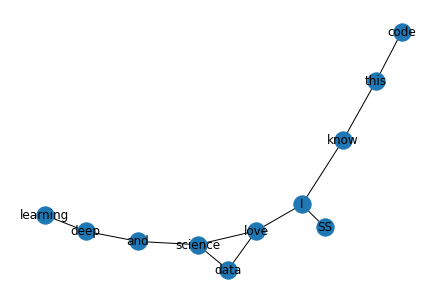

In [14]:
nx.draw(G,with_labels=True)

# 조건부확률 추정

- 어휘 동시 출현 빈도를 이용하면 어휘 동시 출현 확률까지 측정 가능
- 어휘 동시 출현 확률 계산에는 nltk의 ConditionalProbDist를 이용

In [16]:
from nltk.probability import ConditionalProbDist, MLEProbDist

cpd = ConditionalProbDist(cfd, MLEProbDist)
cpd.conditions()

['SS',
 'I',
 'love',
 'data',
 'science',
 'and',
 'deep',
 'learning',
 'know',
 'this',
 'code']

In [17]:
prob_matrix = [] 

for i in cpd.keys(): 
    prob_matrix.append([cpd[i].prob(j) for j in cpd.keys()]) 
    
prob_matrix = np.array(prob_matrix)

print(cpd.keys())
print(prob_matrix)

dict_keys(['SS', 'I', 'love', 'data', 'science', 'and', 'deep', 'learning', 'know', 'this', 'code'])
[[0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.66666667 0.         0.         0.
  0.         0.         0.33333333 0.         0.        ]
 [0.         0.         0.         0.5        0.5        0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.5
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        

In [18]:
df=pd.DataFrame(prob_matrix,index=cpd.keys(),columns=cpd.keys())

df.style.background_gradient(cmap='coolwarm')

,SS,I,love,data,science,and,deep,learning,know,this,code
SS,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
I,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
love,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
data,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
science,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
and,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
deep,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
learning,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
know,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
this,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [19]:
prob_G=nx.from_pandas_adjacency(df)

print(prob_G.nodes())
print(prob_G.edges())

['SS', 'I', 'love', 'data', 'science', 'and', 'deep', 'learning', 'know', 'this', 'code']
[('SS', 'I'), ('I', 'love'), ('I', 'know'), ('love', 'data'), ('love', 'science'), ('data', 'science'), ('science', 'and'), ('and', 'deep'), ('deep', 'learning'), ('know', 'this'), ('this', 'code')]


In [20]:
print(G.edges()[('I','love')])
print(G.edges()[('I','know')])

print(prob_G.edges()[('I','love')])
print(prob_G.edges()[('I','know')])

{'weight': 2}
{'weight': 1}
{'weight': 0.6666666666666666}
{'weight': 0.3333333333333333}


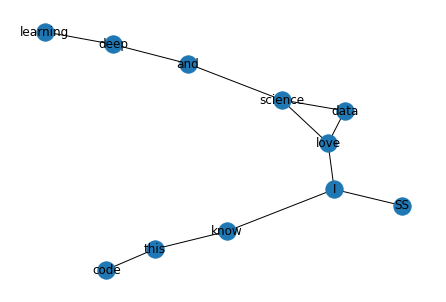

In [21]:
nx.draw(prob_G,with_labels=True)

# 중심성(Centrality) 지수

In [22]:
nx.degree_centrality(G)

{'SS': 0.1,
 'I': 0.30000000000000004,
 'love': 0.30000000000000004,
 'data': 0.2,
 'science': 0.30000000000000004,
 'and': 0.2,
 'deep': 0.2,
 'learning': 0.1,
 'know': 0.2,
 'this': 0.2,
 'code': 0.1}

In [23]:
nx.eigenvector_centrality(G,weight='weight')

{'SS': 0.5218381818736308,
 'I': 0.6738972217471829,
 'love': 0.4289818764298256,
 'data': 0.15246421196699775,
 'science': 0.16168537263306304,
 'and': 0.04494390325361216,
 'deep': 0.012430000571815347,
 'learning': 0.003208839905750058,
 'know': 0.18731685432677989,
 'this': 0.05180118197737535,
 'code': 0.013370793702236268}

In [24]:
nx.betweenness_centrality(G)

{'SS': 0.0,
 'I': 0.6,
 'love': 0.5555555555555556,
 'data': 0.0,
 'science': 0.4666666666666667,
 'and': 0.35555555555555557,
 'deep': 0.2,
 'learning': 0.0,
 'know': 0.35555555555555557,
 'this': 0.2,
 'code': 0.0}

In [26]:
def get_node_size(node_values):
    nsize=np.array([v for v in node_values])
    nsize=1000*(nsize-min(nsize))/(max(nsize)-min(nsize))
    
    return nsize

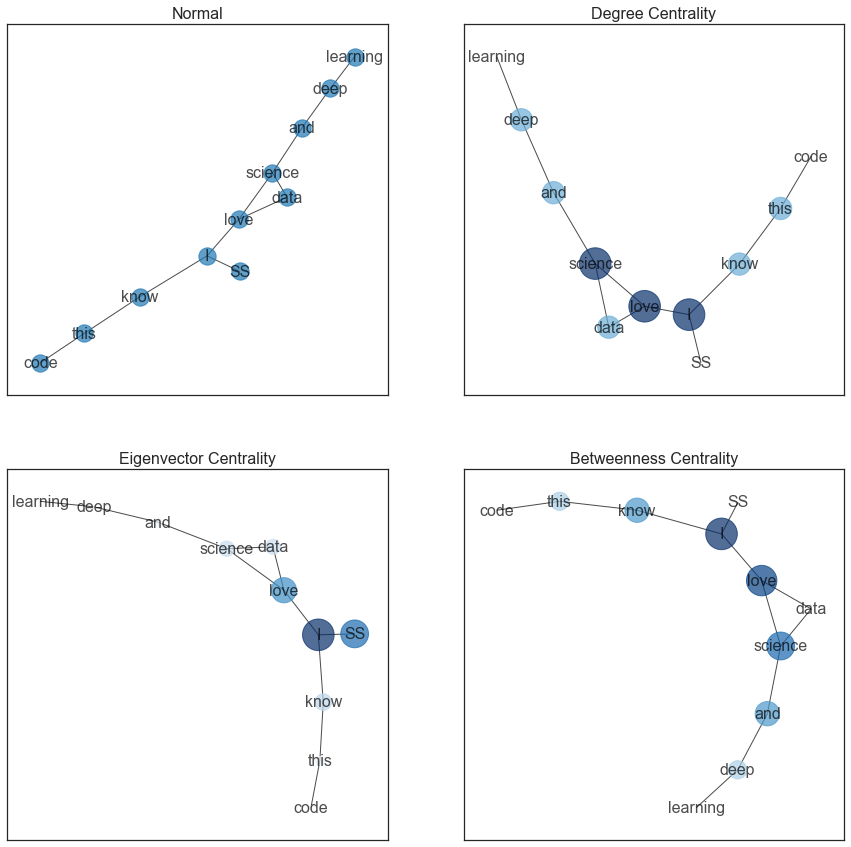

In [27]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white') 

dc = nx.degree_centrality(G).values()
ec = nx.eigenvector_centrality(G, weight='weight').values()
bc = nx.betweenness_centrality(G).values()

plt.figure(figsize=(15, 15))
plt.axis('off') 

plt.subplot(221)
plt.title('Normal', fontsize=16)
nx.draw_networkx(G, font_size=16, alpha=0.7, cmap=plt.cm.Blues) 

plt.subplot(222)
plt.title('Degree Centrality', fontsize=16)
nx.draw_networkx(G, font_size=16, 
                 node_color=list(dc), node_size=get_node_size(dc), 
                 alpha=0.7, cmap=plt.cm.Blues) 

plt.subplot(223)
plt.title('Eigenvector Centrality', fontsize=16)
nx.draw_networkx(G, font_size=16, 
                 node_color=list(ec), node_size=get_node_size(ec), 
                 alpha=0.7, cmap=plt.cm.Blues)

plt.subplot(224)
plt.title('Betweenness Centrality', fontsize=16)
nx.draw_networkx(G, font_size=16, 
                 node_color=list(bc), node_size=get_node_size(bc), 
                 alpha=0.7, cmap=plt.cm.Blues)

plt.show()